<a href="https://colab.research.google.com/github/momokasu1600/html/blob/main/D_%E6%B0%97%E6%B8%A9%E3%81%A8Google%E6%A4%9C%E7%B4%A2%E6%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import io
import json
import datetime as dt

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

Colabに最初から入っていないライブラリをUNIXコマンドの`pip`で導入する。

`japanize-matplotlib`は日本語でmatplotlibが使えるようにするライブラリである。

In [2]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b6658647b2f09c797ea03395277eef5b1a12a77b752ddd1b0e4eb3c9c34d3a7e
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [3]:
# matplotlibの日本語化
import japanize_matplotlib
%matplotlib inline
sns.set(font="IPAexGothic")

Googleドライブを接続し、CSVファイルを自分のドライブに保存する。

認証を求める画面が出る場合がある。

自身でJupyter notebook環境を作っている場合、ディレクトリは適当に読み替えること。

In [4]:
# Googleドライブの接続
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive'

Mounted at /content/drive


プロットの見栄えがするように初期設定する。

In [5]:
# matplotlibの初期設定
plt_config = {
    "figure.dpi": 150,
    "font.size": 14,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "mathtext.cal": "serif",
    "mathtext.rm": "serif",
    "mathtext.it": "serif:italic",
    "mathtext.bf": "serif.bold",
    "mathtext.fontset": "cm",
    "legend.framealpha": 1.0,
    "legend.edgecolor": "black",
    "legend.fancybox": False
}
plt.rcParams.update(plt_config)

# Google検索

特定の検索ワードについて、その検索数の推移を取得できる。

値は検索回数ではなく、検索回数の最大が100になるようスケールされた数である。

https://smart-hint.com/python/pytrends/

In [6]:
!pip install pytrends

In [7]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='ja-JP', tz=-540)

2023-10-09から過去3年間について、キーワードの検索数の推移を取得する。

このとき、取得できるデータは週単位で集計されていることに注意する。

期間を270日以下にすれば、日ごとのデータが取得できる。

注意：日付の範囲を変えると、週ごとのデータの開始日が変わるため、<br>
天気のデータを週ごとにまとめた時indexが整合しないことがある。

In [20]:
kw_list = ['pot-au-feu'] # キーワードのリスト（5個まで）
# 開始、終了日を記述
pytrends.build_payload(kw_list=kw_list,
                       timeframe='2023-10-01 2024-09-30',
                       geo='FR')
df_trends = pytrends.interest_over_time()
df_trends = df_trends.drop('isPartial', axis=1)
df_trends

,pot-au-feu
date,
2023-10-01,19
2023-10-08,25
2023-10-15,61
2023-10-22,72
2023-10-29,91
2023-11-05,100
2023-11-12,74
2023-11-19,76
2023-11-26,91


<Axes: xlabel='date'>

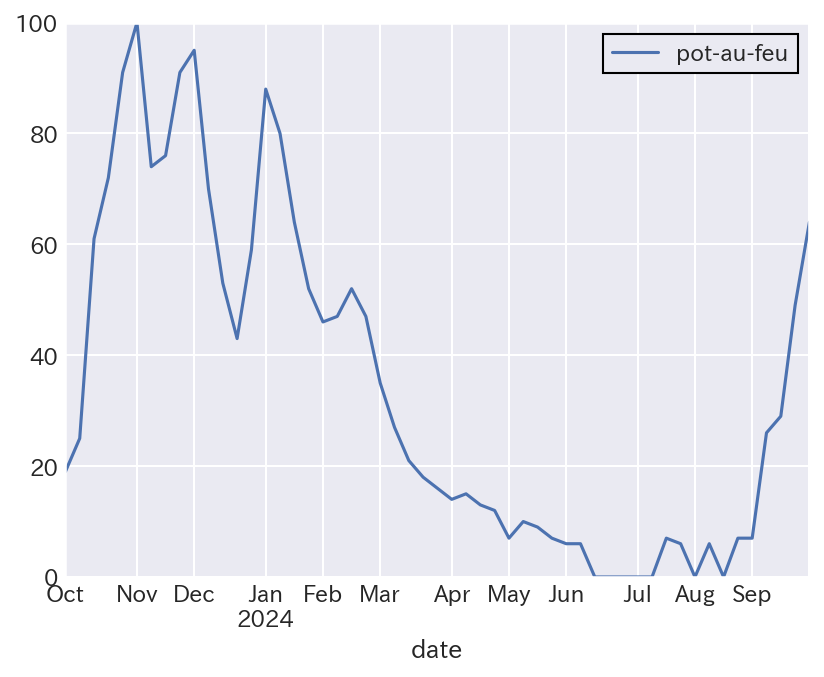

In [21]:
df_trends.plot()

データはCSVファイルとして保存する。

In [22]:
df_trends.to_csv(os.path.join(drive_path, "trends.csv"))

In [23]:
# 保存したCSVファイルを読み込みたい場合、以下のように記述する。
# df_trends = pd.read_csv(os.path.join(drive_path, "trends.csv"))
# df_trends["date"] = pd.to_datetime(df_trends["date"])
# df_trends = df_trends.set_index("date")

# 気温と降水量

気象庁からCSVファイルを取得したものが以下にアップロードされている。

https://www.gifu-nct.ac.jp/elec/ohashi/datascience/weather.csv

このCSVは以下のページで取得できる。

https://www.data.jma.go.jp/gmd/risk/obsdl/

東京の2020-01-01から2023-10-09までの

`日最高気温`, `日最低気温`, `降水量の日合計`, `日照時間`

を選んで出力されたCSVファイルをそのまま使う。

エンコードが`Shift_JIS`であることに注意する。

UNIXコマンド`curl`でGoogleドライブにファイルをダウンロードする。

In [24]:
df_weather = pd.read_csv(("omatase.csv"),
                         names=( "day","av","hy","lo","rain"),
                         usecols=[0,1,2,3,4],
                         encoding="utf-8")
df_weather["day"]=pd.to_datetime(df_weather["day"].str.replace("/","-"))
df_weather

,day,av,hy,lo,rain
0,2023-10-31,11.6,15.5,7.8,1.0
1,2023-11-01,12.1,14.2,10.7,4.0
2,2023-11-02,11.8,14.0,10.1,2.2
3,2023-11-03,7.9,11.1,5.5,0.0
4,2023-11-04,10.7,14.7,7.5,11.0
...,...,...,...,...,...
361,2024-10-26,15.3,20.4,13.7,0.2
362,2024-10-27,15.2,17.7,13.5,0.0
363,2024-10-28,13.5,16.8,11.1,0.4
364,2024-10-29,11.4,12.4,9.9,0.0


array([<Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>], dtype=object)

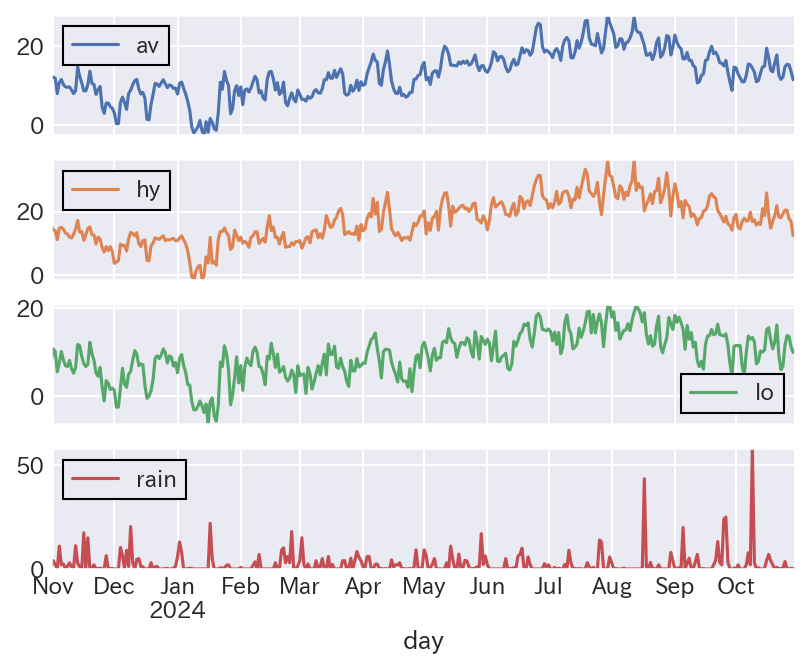

In [25]:
# index（横軸）を日付にしてからプロット
df_weather.set_index("day").plot(subplots=True)

# 相関関係の分析

上のデータから任意の2データを選び、相関関係を分析する。

2つのDataFrameを結合したいが、Googleトレンドは週単位、

天気は日単位になっているため、週単位に揃える。

天気のデータについて、1週間ごとの平均をとる。

In [26]:
# 日曜日を始まりとして、1週間ごとの平均をとる
df_weekly_weather = df_weather.groupby(pd.Grouper(key='day', freq='W-SUN')).mean().reset_index()
df_weekly_weather = df_weekly_weather.set_index("day")
df_weekly_weather

,av,hy,lo,rain
day,,,,
2023-11-05,10.933333,14.083333,8.616667,3.366667
2023-11-12,9.185714,13.042857,6.828571,2.800000
2023-11-19,11.214286,13.957143,9.371429,5.171429
2023-11-26,7.771429,10.571429,5.000000,0.485714
2023-12-03,3.342857,6.400000,0.857143,1.028571
2023-12-10,7.000000,10.485714,4.528571,7.228571
2023-12-17,7.985714,10.114286,6.142857,1.685714
2023-12-24,7.900000,9.957143,5.785714,0.771429
2023-12-31,9.957143,11.257143,8.614286,0.285714


DataFrameを結合する。

`index`つまり`date`が共通の列だけを結合した新たなDataFrameを作る。

In [27]:
# 2つのdfでindexが共通の列だけを結合する
df_concat = pd.concat([df_trends, df_weekly_weather], axis=1, join="inner")
df_concat

,pot-au-feu,av,hy,lo,rain
2023-11-05,100,10.933333,14.083333,8.616667,3.366667
2023-11-12,74,9.185714,13.042857,6.828571,2.800000
2023-11-19,76,11.214286,13.957143,9.371429,5.171429
2023-11-26,91,7.771429,10.571429,5.000000,0.485714
2023-12-03,95,3.342857,6.400000,0.857143,1.028571
2023-12-10,70,7.000000,10.485714,4.528571,7.228571
2023-12-17,53,7.985714,10.114286,6.142857,1.685714
2023-12-24,43,7.900000,9.957143,5.785714,0.771429
2023-12-31,59,9.957143,11.257143,8.614286,0.285714
2024-01-07,88,7.942857,9.542857,5.814286,3.942857



それぞれの変数をプロットしてみる。

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

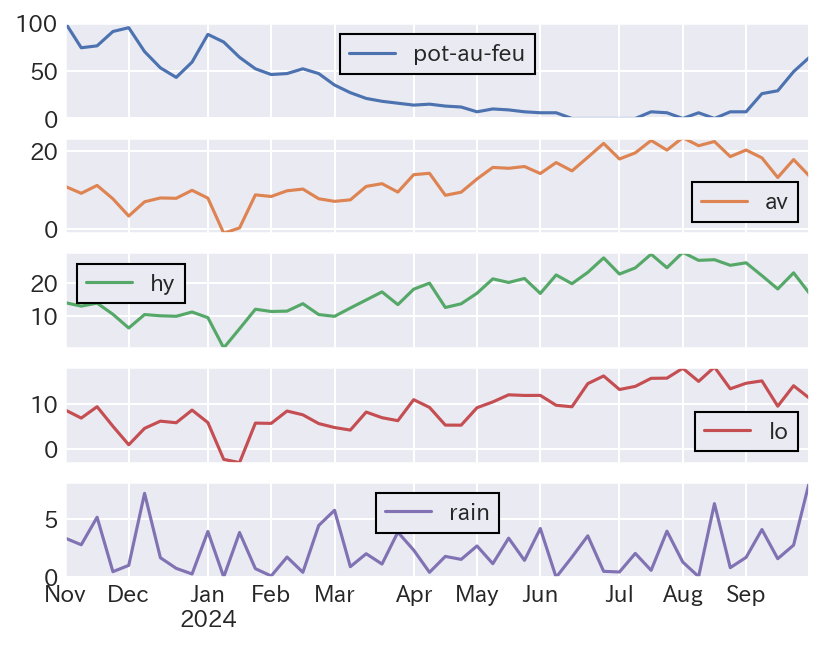

In [28]:
df_concat.plot(subplots=True)

matplotlibのラッパーである`seaborn`ライブラリを使って、

すべての組み合わせの2変数で散布図を作成できる。

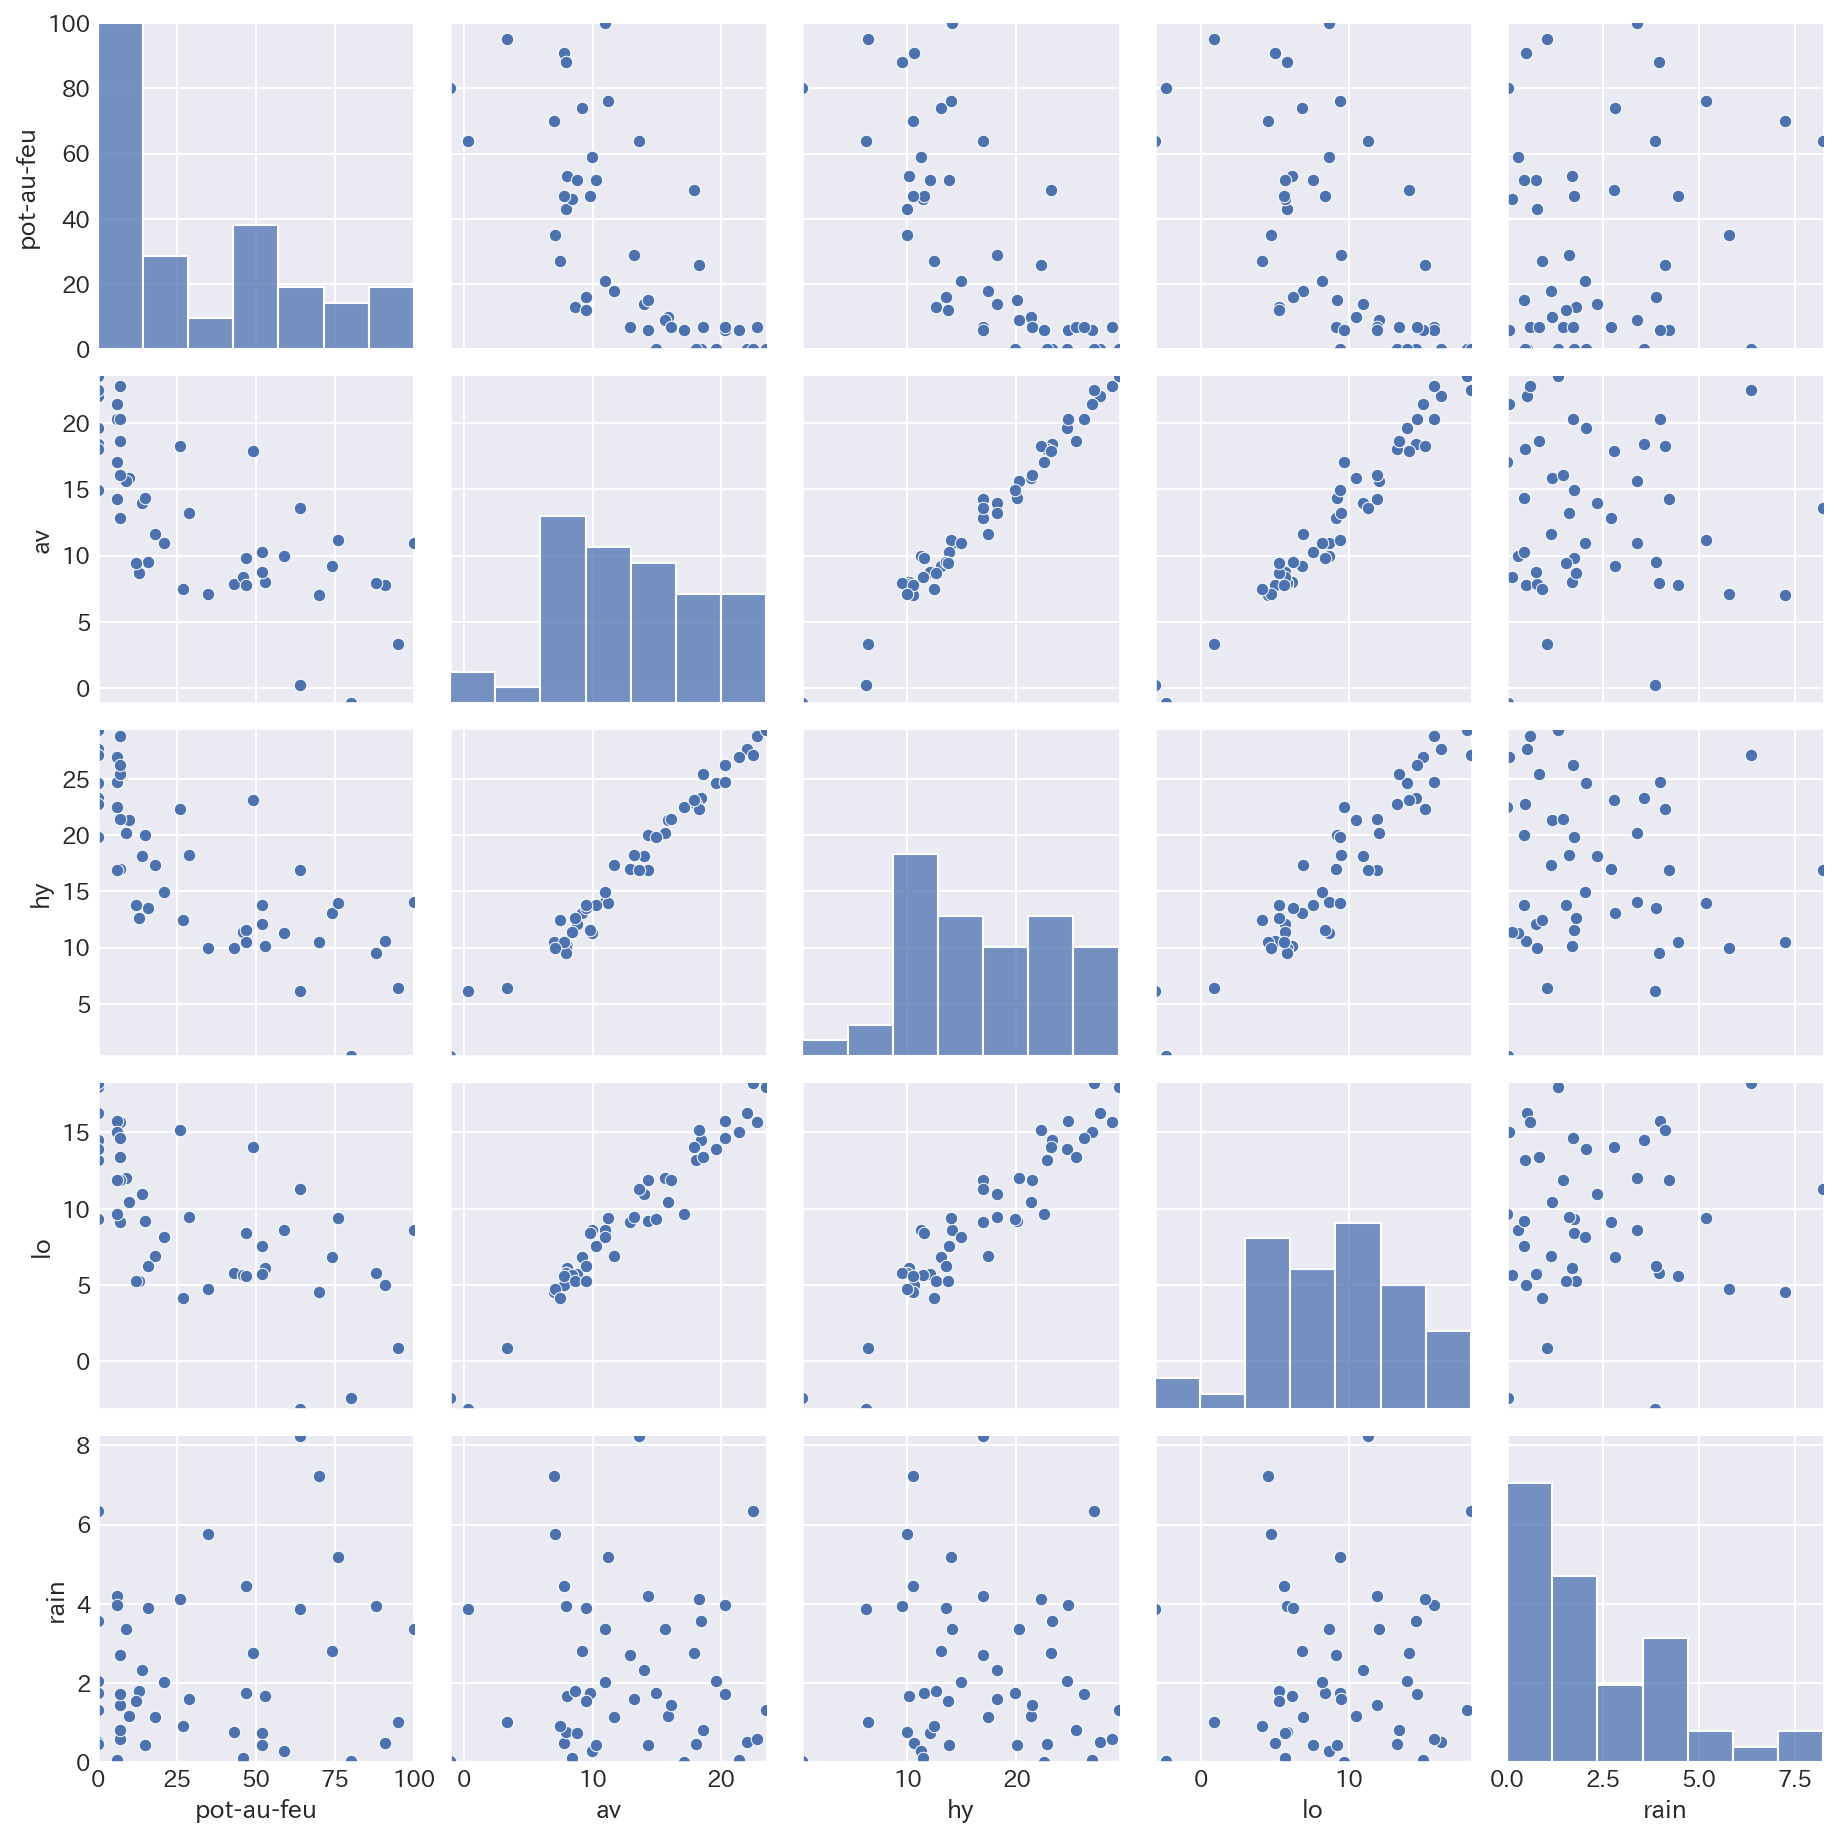

In [29]:
sns.pairplot(df_concat)

散布図を描くことで、2変数がどのように関係しているか直感的に確認できる。

この図をもとに考察してもよい。

これらの相関係数を求める。

3変数以上ある場合にも、相互に相関係数を求められる。

<Axes: >

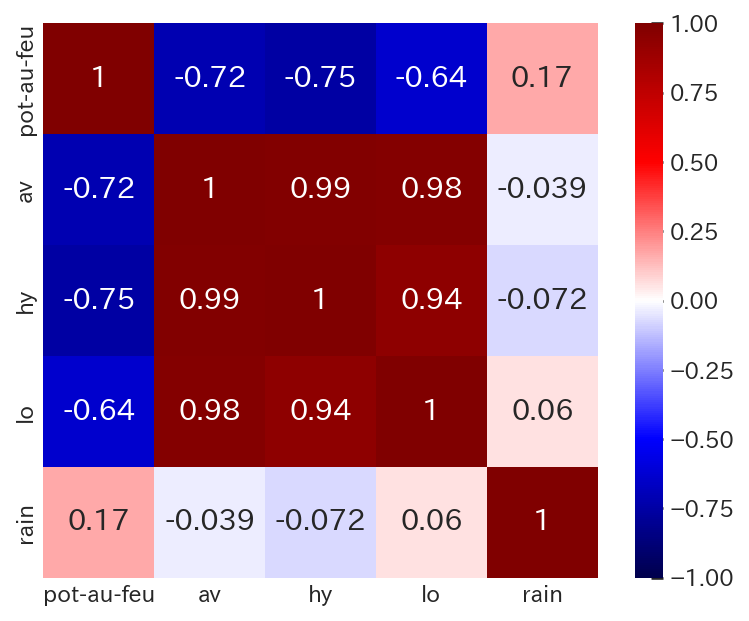

In [30]:
corr = df_concat.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0,
            cmap="seismic", square=True, annot=True)

今回は、`鍋`の検索数と最大気温`maxtemp`に着目する。

最大気温が上がると鍋の検索数が減る強い負の相関がある。

# 単回帰分析

任意の1変数を目的変数(y軸)、別の任意の1変数を説明変数(x軸)として、

単回帰分析を行う。

まず、機械学習のためのライブラリscikit-learnから

単回帰分析のためのモジュールを読み込む。

In [31]:
from sklearn import linear_model

In [34]:
clf = linear_model.LinearRegression()
X = df_concat[["hy"]]
Y = df_concat[["pot-au-feu"]]
clf.fit(X, Y)

print("回帰係数: " + str(clf.coef_))
print("切片: " + str(clf.intercept_))
print("決定係数: " + str(clf.score(X, Y)))

回帰係数: [[-3.35700904]]
切片: [89.37404942]
決定係数: 0.5628999578267614


ある程度の決定係数があるため、このモデルでは目的変数を説明変数である程度説明できている。

回帰直線を散布図に重ねて描くと以下のようになる。

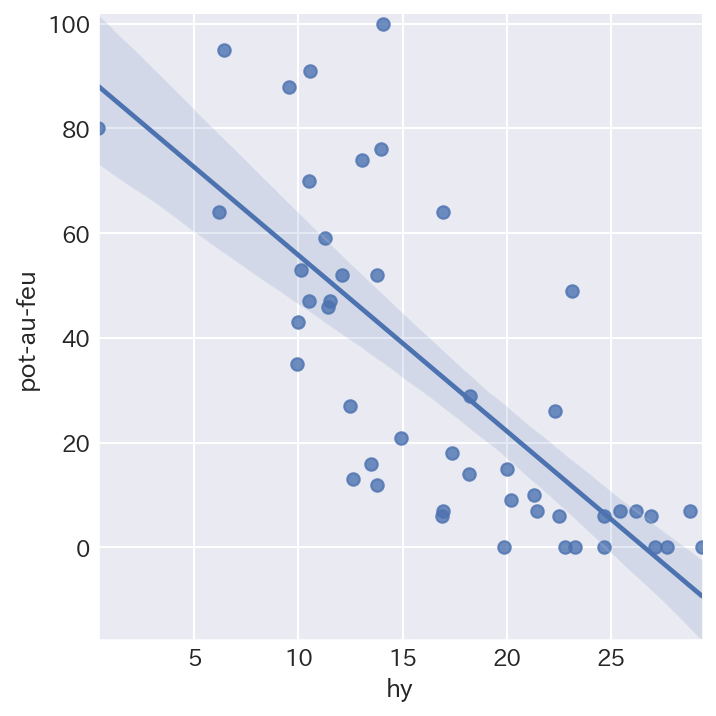

In [36]:
sns.lmplot(x="hy", y="pot-au-feu", data=df_concat)

グラフからも、おおむね回帰直線に沿ってデータがあることがわかる。